In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

In [2]:
# juxtapose fivemers.csv, 8a-mut-freq.csv, and 9a-mut-freq.csv
fivemers = pd.read_csv('fivemers.csv')
fivemers.columns = ['Fivemer']
mut8a = pd.read_csv('8a_mut_freq.csv')
mut9a = pd.read_csv('9a_mut_freq.csv')
mut11a = pd.read_csv('11a_mut_freq.csv')
df = pd.concat([fivemers, mut8a, mut9a, mut11a], axis=1)

mutability = pd.read_csv('../nextflow/data/mutability/MK_RS5NF_mutability.csv', sep=' ')

df = df.merge(mutability, on='Fivemer')

# set a lower threshold of 1e-6 for all mut_freq columns
df[['8a_mut_freq', '9a_mut_freq', '11a_mut_freq']] = df[['8a_mut_freq', '9a_mut_freq', '11a_mut_freq']].clip(lower=1e-5)
# get the min of each _mut_freq column
df[['8a_mut_freq', '9a_mut_freq', '11a_mut_freq']].min(axis=0)


8a_mut_freq     0.000010
9a_mut_freq     0.000054
11a_mut_freq    0.000033
dtype: float64

In [3]:
def represent_degenerate_motif(degenerate_motif):
    # Map of degenerate nucleotide symbols to their corresponding regular expression
    degenerate_nucleotide_map = {
        'W': '[AT]',
        'R': '[AG]',
        'Y': '[CT]',
        'C': 'C',
        'N': '[ACGT]',
        'S': '[CG]',
        'M': '[AC]',
        'K': '[GT]',
        'G': 'G',
        'A': 'A',
        'T': 'T',
    }

    # Convert degenerate motif to regex pattern
    regex_pattern = ''.join([degenerate_nucleotide_map[base] for base in degenerate_motif])
    return regex_pattern

def matches_RGYW(kmer):
    if len(kmer) != 5:
        return False

    # Define the motifs using degenerate base notation
    motif_WRCYN = 'WRCYN'
    motif_NRGYW = 'NRGYW'

    # Represent these motifs as regex patterns
    regex_WRCYN = represent_degenerate_motif(motif_WRCYN)
    regex_NRGYW = represent_degenerate_motif(motif_NRGYW)

    # Check if the kmer matches either of the motifs
    return bool(re.match(regex_WRCYN, kmer)) or bool(re.match(regex_NRGYW, kmer))

assert matches_RGYW("AAGCT") == True


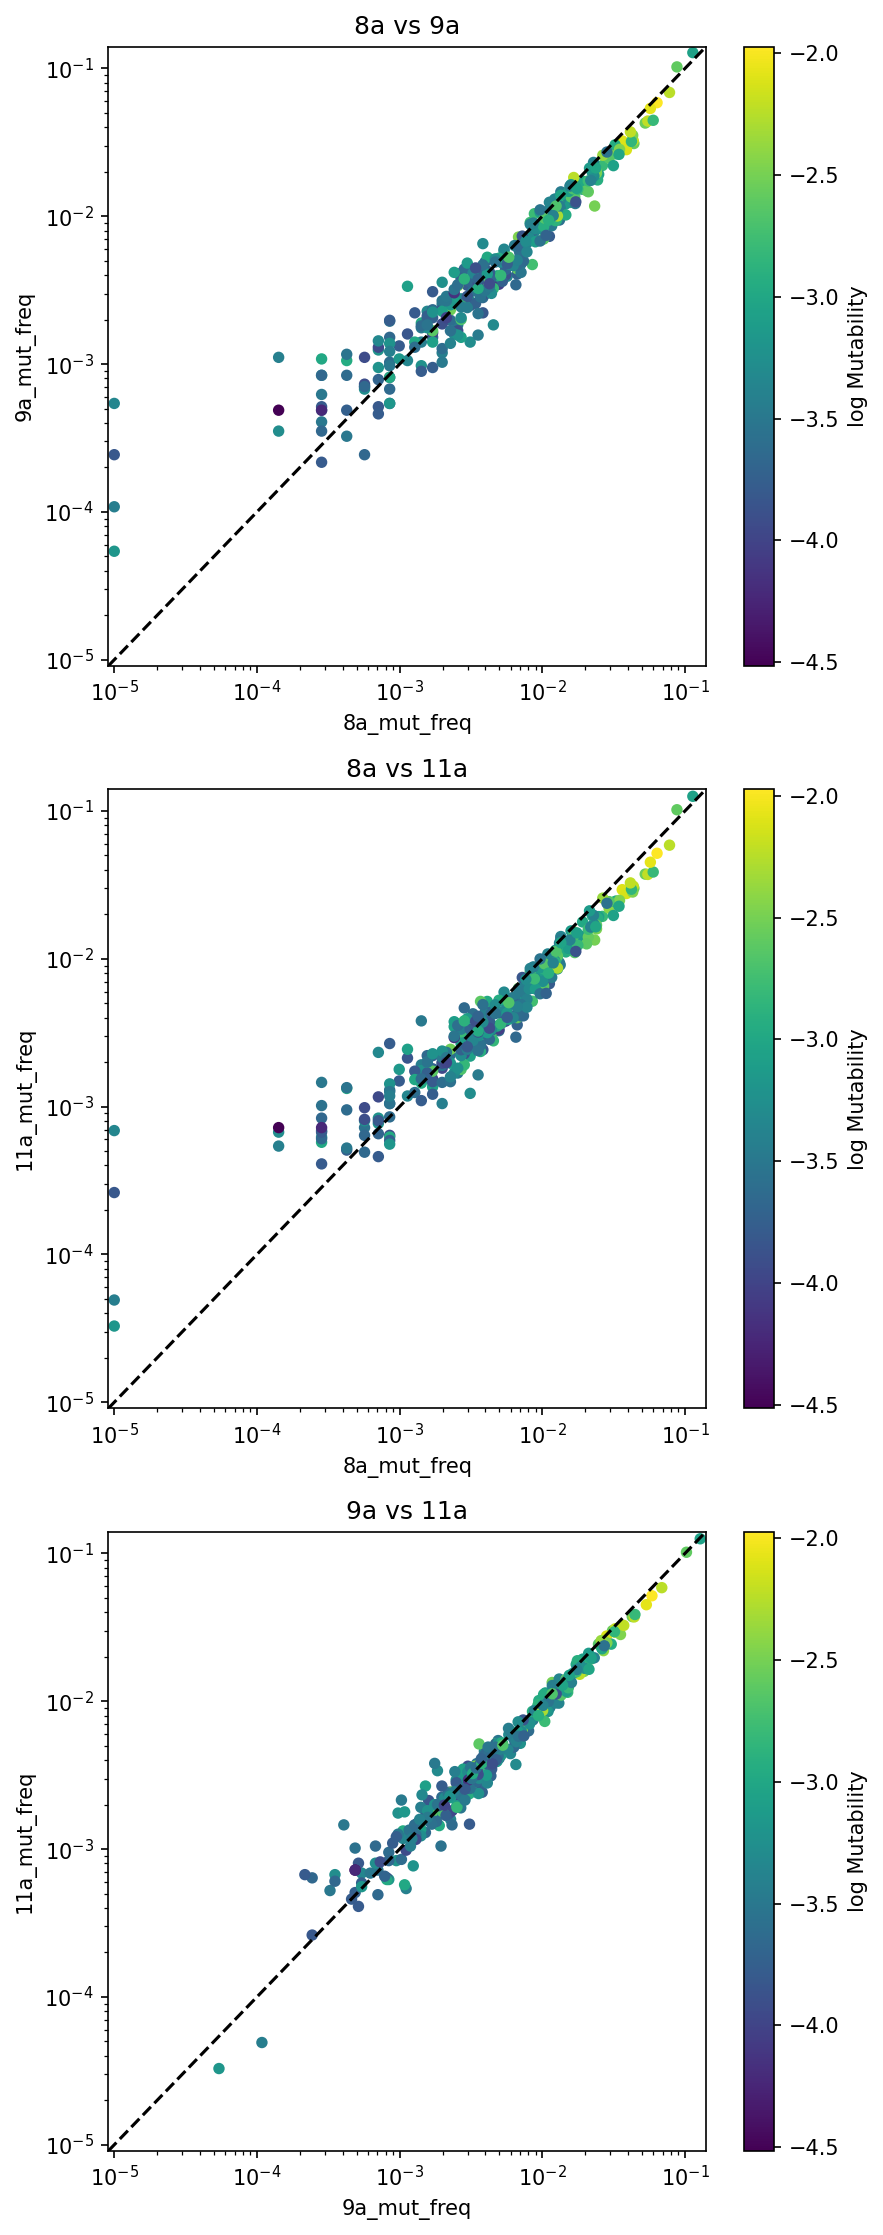

In [4]:
df['log Mutability'] = np.log10(df['Mutability'])

#df.plot.scatter(x='8a-mut-freq', y='9a-mut-freq', c='log Mutability', colormap='viridis', loglog=True)

min_limit = min(df['8a_mut_freq'].min(), df['9a_mut_freq'].min(), df['11a_mut_freq'].min())/1.1
max_limit = max(df['8a_mut_freq'].max(), df['9a_mut_freq'].max(), df['11a_mut_freq'].max())*1.1

def set_limits_and_styles(ax, title, min_limit, max_limit):
    ax.set_title(title)
    ax.set_xlim(min_limit, max_limit)
    ax.set_ylim(min_limit, max_limit)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot([min_limit, max_limit], [min_limit, max_limit], 'k--')  # Add x=y line


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 15))

# Plot each scatter plot
df.plot.scatter(x='8a_mut_freq', y='9a_mut_freq', c='log Mutability', colormap='viridis', loglog=True, ax=axs[0])
set_limits_and_styles(axs[0], '8a vs 9a', min_limit, max_limit)

df.plot.scatter(x='8a_mut_freq', y='11a_mut_freq', c='log Mutability', colormap='viridis', loglog=True, ax=axs[1])
set_limits_and_styles(axs[1], '8a vs 11a', min_limit, max_limit)

df.plot.scatter(x='9a_mut_freq', y='11a_mut_freq', c='log Mutability', colormap='viridis', loglog=True, ax=axs[2])
set_limits_and_styles(axs[2], '9a vs 11a', min_limit, max_limit)

plt.tight_layout()
plt.show()


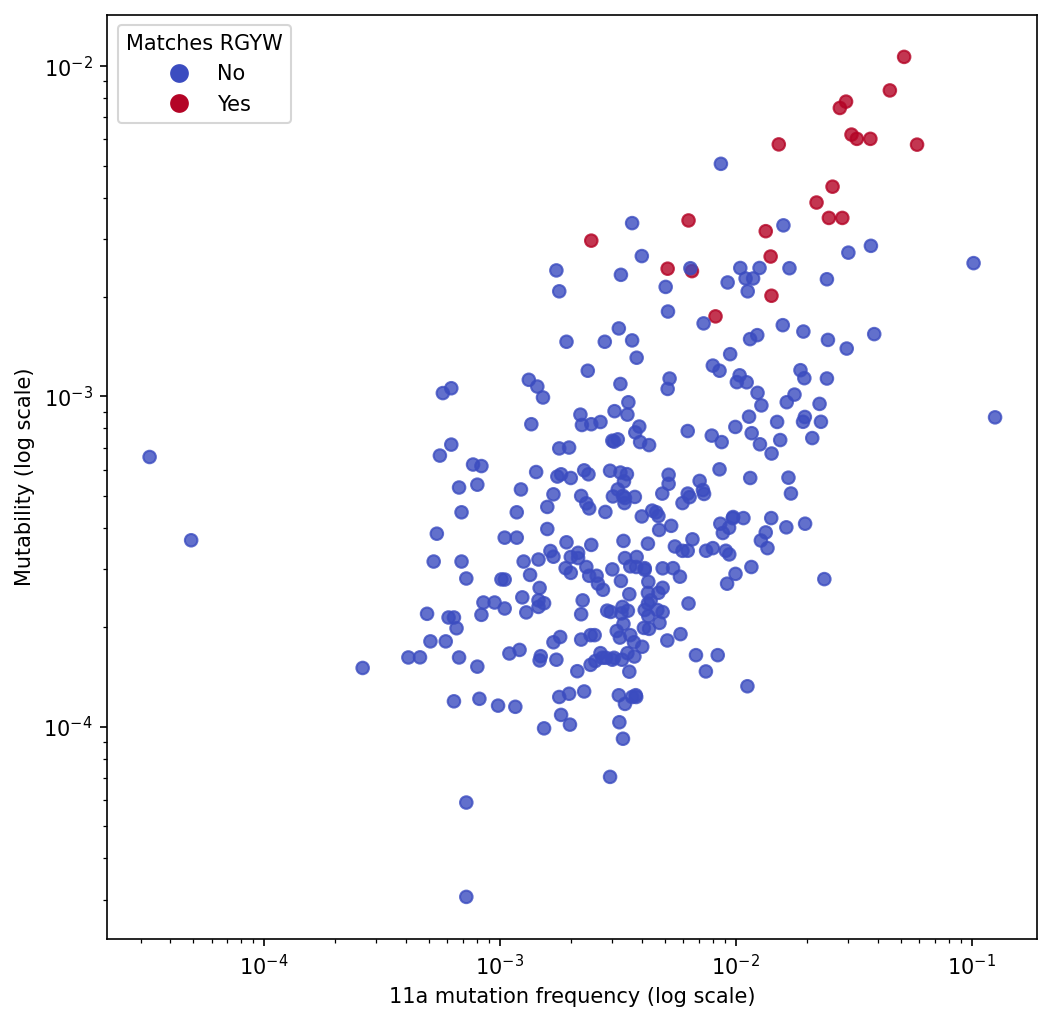

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it has columns 'Fivemer', '8a-mut-freq', 'Mutability'

# Apply the matches_RGYW function to the 'Fivemer' column
df['matches_RGYW'] = df['Fivemer'].apply(matches_RGYW)

# Create a scatter plot
plt.figure(figsize=(8, 8))  # Square aspect ratio
scatter = plt.scatter(df['11a_mut_freq'], df['Mutability'], c=df['matches_RGYW'], cmap='coolwarm', alpha=0.8)

# Set x and y axes to logarithmic scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel('11a mutation frequency (log scale)')
plt.ylabel('Mutability (log scale)')

# Create a custom legend
legend_labels = ['No', 'Yes']
handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i], 
                      markersize=10, markerfacecolor=scatter.cmap(scatter.norm(i))) for i in range(2)]
plt.legend(handles, legend_labels, title="Matches RGYW")

plt.show()
